In [1]:
import numpy as np
import pandas as pd 
import sklearn as sk 
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
# model development
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
# model evaluation
from sklearn import metrics

from scipy.stats import ttest_ind

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data Cleaning and Trim Outliers

In [2]:
custom = pd.read_csv('custom_audience_ads.csv')
lookalike = pd.read_csv('lookalike_data.csv')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
custom.head(1)

,account_id,approximate_count,custom_audience_id,name,retention_days,time_created,customer_file_source,description,is_value_based,data_source_type,...,data_source_creation_params,ad_id,clicks,cpc,impressions,cpm,ctr,comments,video_views,post_reactions
0,104657973074389,1000,6084391234802,Thermador: Retargeting Users who watched Amand...,365,2017-12-08 19:29:08,NOT_APPLICABLE,NaN,False,EVENT_BASED,...,"{""prefill"":""true""}",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
print('Shape of the original custom audience dataset: ',custom.shape)

Shape of the original custom audience dataset:  (885931, 21)


In [5]:
custom['time_created'] = pd.to_datetime(custom['time_created'])

In [6]:
custom['month'] = custom['time_created'].dt.month
custom['year'] = custom['time_created'].dt.year
custom['day'] = custom['time_created'].dt.day

In [7]:
custom = custom.drop(columns =['description'])
custom = custom.drop(columns =['comments'])

In [8]:
custom_clean = custom.dropna() #remove missing value and empty columns

In [9]:
#Trim outliers:
starting_percentile = custom_clean['clicks'].quantile(.02)
ending_percentile = custom_clean['clicks'].quantile(.98)
price_outliers_df = custom_clean.loc[((custom_clean['clicks'] <= starting_percentile) | (custom_clean['clicks'] >= ending_percentile))]
custom_clean = custom_clean.loc[((custom_clean['clicks'] > starting_percentile) & (custom_clean['clicks'] < ending_percentile))]

In [10]:
print('Shape of the cleaned custom audience dataset: ', custom_clean.shape)

Shape of the cleaned custom audience dataset:  (666504, 22)


Lookalike

In [11]:
lookalike.head(1)

,country,ratio,origin_id,origin_name,origin_type
0,US,0.08,6071223636402,Everyone Who Engaged With MTV Page,custom_audience


In [12]:
lookalike = lookalike.replace({'AL,AD,AT,BY,BE,BA,BG,HR,CZ,DK,EE,FO,FI,FR,DE,GI,GR,GG,HU,IS,IE,IM,IT,JE,XK,LV,LI,LT,LU,MK,MT,MD,MC,ME,NL,NO,PL,PT,RO,RU,SM,RS,SK,SI,ES,SJ,SE,CH,UA,GB':'other countries'})

In [13]:
lookalike.shape

(1078, 5)

In [14]:
# Remove duplicate from 1078 to 928 rows 
looklike_de = lookalike.drop_duplicates(subset='origin_id', keep='first', inplace=False, ignore_index=False)
looklike_de.shape


(928, 5)

# Exploratory Data Analysis

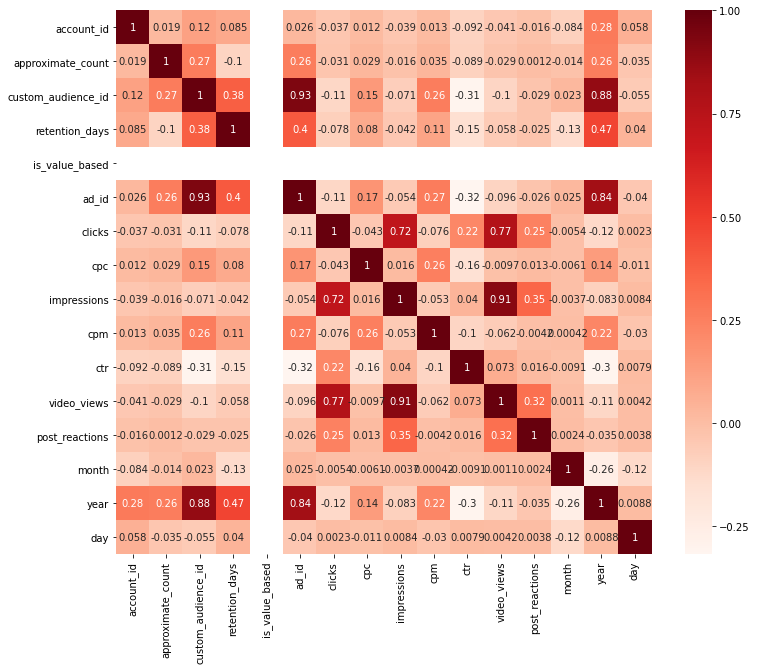

In [15]:
#Generating correlation heatmap
plt.figure(figsize=(12,10))
cor = custom.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

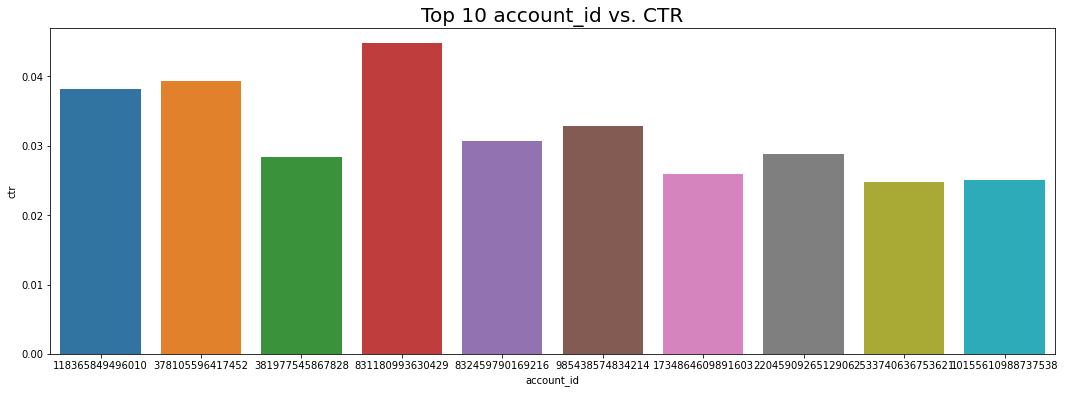

In [16]:
grouped_account=custom_clean.groupby(by='account_id',as_index=False)['ctr'].mean()
sorted_grouped_account=grouped_account.sort_values(by='ctr',ascending=False)
top10=sorted_grouped_account.iloc[0:10]
plt.figure(figsize=(18,6))
plt.title('Top 10 account_id vs. CTR', size=20)
sns.barplot('account_id','ctr',data=top10)

In [17]:
top10.head()

,account_id,ctr
29,831180993630429,0.044777
12,378105596417452,0.039271
1,118365849496010,0.038162
32,985438574834214,0.032911
30,832459790169216,0.030700


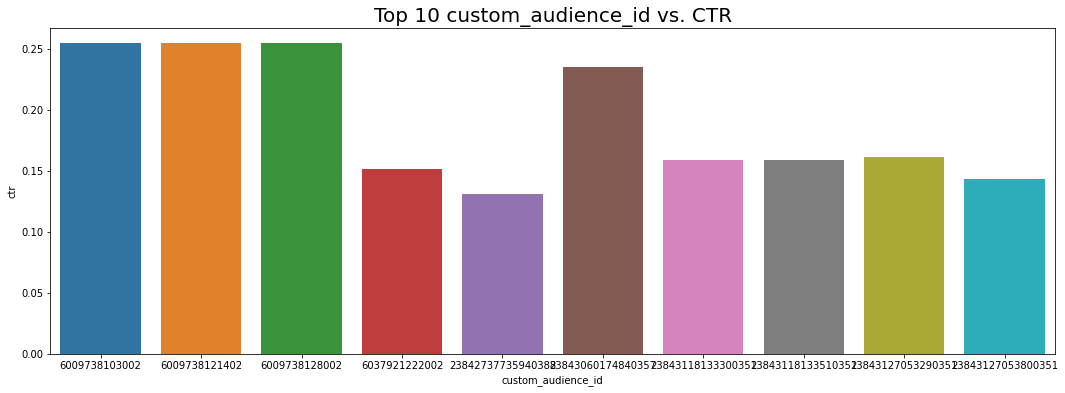

In [18]:
grouped_account=custom_clean.groupby(by='custom_audience_id',as_index=False)['ctr'].mean()
sorted_grouped_account=grouped_account.sort_values(by='ctr',ascending=False)
top10=sorted_grouped_account.iloc[0:10]
plt.figure(figsize=(18,6))
plt.title('Top 10 custom_audience_id vs. CTR', size=20)
sns.barplot('custom_audience_id','ctr',data=top10)

In [19]:
top10.head()

,custom_audience_id,ctr
0,6009738103002,0.254572
2,6009738128002,0.254572
1,6009738121402,0.254572
2356,23843060174840357,0.234825
2524,23843127053290351,0.161162


<strong>What's the average CTR daily?</strong>

In [20]:
date_count = custom_clean.groupby(by='time_created').mean()
average_ctr = date_count['ctr'].mean()
points = len(date_count.index)

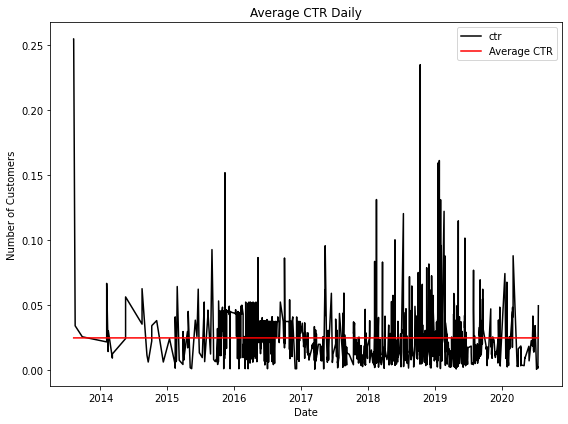

In [21]:
plt.figure(figsize=(8,6))
plt.plot(date_count.index, date_count['ctr'], c='black', label = 'ctr')
plt.plot(date_count.index, np.linspace(average_ctr,average_ctr,points), c='r', label = 'Average CTR')
plt.title('Average CTR Daily')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Number of Customers')
plt.tight_layout()

<strong>What's the Average Impressions Daily?</strong>

In [22]:
date_count = custom_clean.groupby(by='time_created').mean()
average_impressions = date_count['impressions'].mean()
points = len(date_count.index)

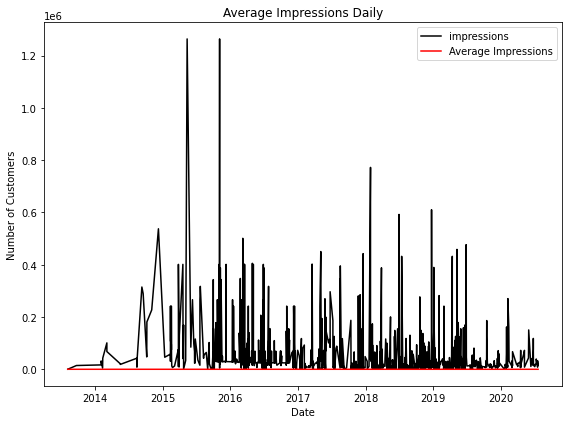

In [23]:
plt.figure(figsize=(8,6))
plt.plot(date_count.index, date_count['impressions'], c='black', label = 'impressions')
plt.plot(date_count.index, np.linspace(average_ctr,average_ctr,points), c='r', label = 'Average Impressions')
plt.title('Average Impressions Daily')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Number of Customers')
plt.tight_layout()

<strong>What's the Average CPC Daily?</strong>

In [24]:
date_count = custom_clean.groupby(by='time_created').mean()
average_cpc = date_count['cpc'].mean()
points = len(date_count.index)

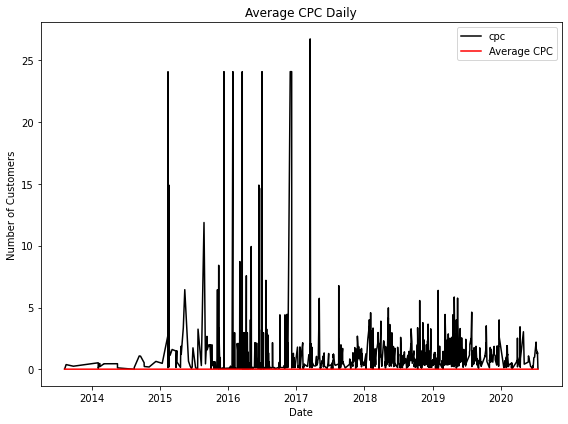

In [25]:
plt.figure(figsize=(8,6))
plt.plot(date_count.index, date_count['cpc'], c='black', label = 'cpc')
plt.plot(date_count.index, np.linspace(average_ctr,average_ctr,points), c='r', label = 'Average CPC')
plt.title('Average CPC Daily')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Number of Customers')
plt.tight_layout()

<strong>What's the Average CPM Daily?</strong>

In [26]:
date_count = custom_clean.groupby(by='time_created').mean()
average_cpm = date_count['cpm'].mean()
points = len(date_count.index)

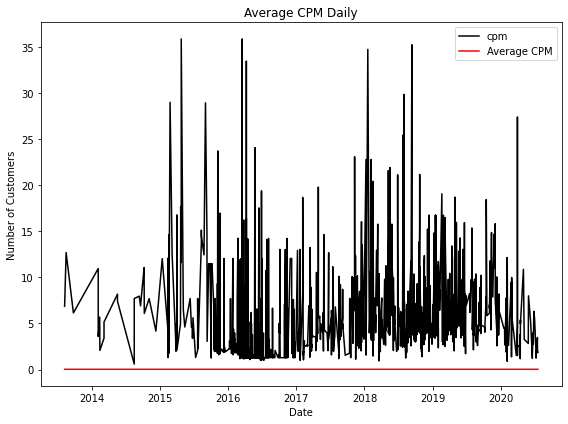

In [27]:
plt.figure(figsize=(8,6))
plt.plot(date_count.index, date_count['cpm'], c='black', label = 'cpm')
plt.plot(date_count.index, np.linspace(average_ctr,average_ctr,points), c='r', label = 'Average CPM')
plt.title('Average CPM Daily')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Number of Customers')
plt.tight_layout()

Text(0, 0.5, 'Counts')

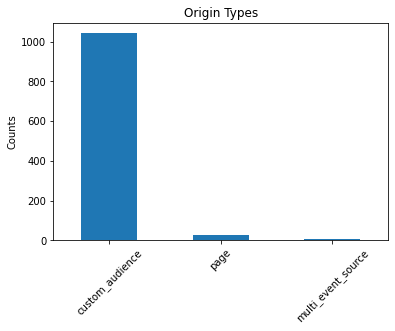

In [28]:
lookalike['origin_type'].value_counts().plot(kind='bar')
plt.xticks(rotation=45)
plt.title('Origin Types')
plt.ylabel('Counts')

Text(0, 0.5, 'Counts')

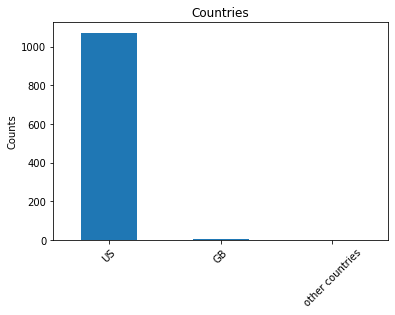

In [29]:
lookalike['country'].value_counts().plot(kind='bar')
plt.xticks(rotation=45)
plt.title('Countries')
plt.ylabel('Counts')

P1. What are the attributes of custom audience that result in large reach?

In [30]:
# find out all features result in large impression(correlation > 0.5) and low cpm(correlation <0)
relevant_featuresP1 = cor[(cor["cpm"]<0) & (cor['impressions'] > 0.5) & (cor['impressions'] < 1)]
relevant_featuresP1


,account_id,approximate_count,custom_audience_id,retention_days,is_value_based,ad_id,clicks,cpc,impressions,cpm,ctr,video_views,post_reactions,month,year,day
clicks,-0.036840,-0.030613,-0.109770,-0.077803,NaN,-0.108044,1.000000,-0.042596,0.720548,-0.075547,0.220951,0.771451,0.248492,-0.005397,-0.117431,0.002325
video_views,-0.040758,-0.028772,-0.101308,-0.057745,NaN,-0.096005,0.771451,-0.009743,0.910128,-0.061703,0.072891,1.000000,0.316062,0.001056,-0.108916,0.004237


In [31]:
#result table for P1
p1 = print(relevant_featuresP1[["impressions",'cpm']])

             impressions       cpm
clicks          0.720548 -0.075547
video_views     0.910128 -0.061703


P2.What are the attributes of custom audience that result in high engagement?

In [32]:
# find out all features result in large clicks(correlation > 0) and low cpc(correlation <0)
relevant_featuresP2 = cor[(cor["cpc"]<0) & (cor['clicks'] > 0) & (cor['clicks'] < 1)]
relevant_featuresP2

,account_id,approximate_count,custom_audience_id,retention_days,is_value_based,ad_id,clicks,cpc,impressions,cpm,ctr,video_views,post_reactions,month,year,day
ctr,-0.091720,-0.089301,-0.305780,-0.148353,NaN,-0.317070,0.220951,-0.161713,0.039922,-0.104878,1.000000,0.072891,0.016089,-0.009146,-0.304399,0.007893
video_views,-0.040758,-0.028772,-0.101308,-0.057745,NaN,-0.096005,0.771451,-0.009743,0.910128,-0.061703,0.072891,1.000000,0.316062,0.001056,-0.108916,0.004237
day,0.058281,-0.034614,-0.055274,0.039607,NaN,-0.039582,0.002325,-0.011002,0.008391,-0.029503,0.007893,0.004237,0.003819,-0.124627,0.008757,1.000000


In [33]:
#result table for P2
p2 = print(relevant_featuresP2[["clicks",'cpc']])

               clicks       cpc
ctr          0.220951 -0.161713
video_views  0.771451 -0.009743
day          0.002325 -0.011002


P3. What are the attributes of custom audience that result in high efficiency for determined by CTR?

In [34]:
# find out all features result in high ctr(correlation > 0.05) and low cpc(correlation <0)
relevant_featuresP3 = cor[(cor["cpc"]<0) & (cor['ctr'] > 0.05) & (cor['ctr'] < 1)]
relevant_featuresP3

,account_id,approximate_count,custom_audience_id,retention_days,is_value_based,ad_id,clicks,cpc,impressions,cpm,ctr,video_views,post_reactions,month,year,day
clicks,-0.036840,-0.030613,-0.109770,-0.077803,NaN,-0.108044,1.000000,-0.042596,0.720548,-0.075547,0.220951,0.771451,0.248492,-0.005397,-0.117431,0.002325
video_views,-0.040758,-0.028772,-0.101308,-0.057745,NaN,-0.096005,0.771451,-0.009743,0.910128,-0.061703,0.072891,1.000000,0.316062,0.001056,-0.108916,0.004237


In [35]:
# table for the result of P3
P3 = print(relevant_featuresP3[["ctr",'cpc']])

                  ctr       cpc
clicks       0.220951 -0.042596
video_views  0.072891 -0.009743


## Model Development - Linear Regression

CPM

In [36]:
X = custom_clean[['approximate_count', 'retention_days','cpc', 'impressions',
                  'clicks', 'ctr', 'video_views', 'post_reactions','month','day','year']]
y = custom_clean['cpm']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)

In [38]:
lm = LinearRegression()

In [39]:
lm.fit(X_train,y_train)
print(lm.intercept_)

-1885.7322371696257


CPC

In [40]:
X1 = custom_clean[['approximate_count', 'retention_days','cpm', 'impressions',
                  'clicks', 'ctr', 'video_views', 'post_reactions','month','day','year']]
y1 = custom_clean['cpc']

In [41]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.4, random_state=101)

In [42]:
lm1 = LinearRegression()
lm1.fit(X1_train,y1_train)
print(lm1.intercept_)

-69.55000582667643


CTR

In [43]:
X2 = custom_clean[['approximate_count', 'retention_days','cpm', 'impressions',
                  'clicks', 'cpc', 'video_views', 'post_reactions','month','day','year']]
y2 = custom_clean['ctr']

In [44]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.4, random_state=101)

In [45]:
lm2 = LinearRegression()
lm2.fit(X2_train,y2_train)
print(lm2.intercept_)

13.447353244496375


## Model Evaluation - Linear Regression

CPM

In [46]:
# print the intercept
print(lm.intercept_)

-1885.7322371696257


In [47]:
coeff_df = pd.DataFrame(lm.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
approximate_count,-1.304745e-08
retention_days,-1.146995e-03
cpc,4.813306e-01
impressions,3.775578e-08
clicks,-1.591115e-04
ctr,3.305994e+00
video_views,-1.712018e-06
post_reactions,8.906804e-05
month,7.519293e-02
day,-1.186791e-02


In [48]:
predictions = lm.predict(X_test)

In [49]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 1.8972842082723296
MSE: 17.246899831865736
RMSE: 4.152938698303376


CPC

In [50]:
coeff_df1 = pd.DataFrame(lm1.coef_,X1.columns,columns=['Coefficient'])
coeff_df1

,Coefficient
approximate_count,-8.365520e-11
retention_days,4.177484e-04
cpm,1.040688e-01
impressions,3.454328e-06
clicks,-4.533620e-05
ctr,-6.697668e+00
video_views,-5.140289e-06
post_reactions,4.021578e-06
month,8.529325e-04
day,-1.728358e-03


In [51]:
# Evalution on testing data
predictions1 = lm1.predict(X1_test)
print('MAE:', metrics.mean_absolute_error(y1_test, predictions1))
print('MSE:', metrics.mean_squared_error(y1_test, predictions1))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y1_test, predictions1)))

MAE: 0.40638960359323567
MSE: 3.45362484005471
RMSE: 1.8583930800707125


CTR

In [52]:
coeff_df2 = pd.DataFrame(lm2.coef_,X2.columns,columns=['Coefficient'])
coeff_df2

,Coefficient
approximate_count,3.630924e-12
retention_days,8.634165e-06
cpm,1.644010e-04
impressions,-8.963377e-08
clicks,7.618874e-06
cpc,-1.540455e-03
video_views,-2.681873e-07
post_reactions,2.733687e-07
month,-6.502131e-04
day,-1.600860e-05


In [53]:
# Evalution on testing data
predictions2 = lm2.predict(X2_test)
print('MAE:', metrics.mean_absolute_error(y2_test, predictions2))
print('MSE:', metrics.mean_squared_error(y2_test, predictions2))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y2_test, predictions2)))

MAE: 0.01970483409115883
MSE: 0.0008288822708557689
RMSE: 0.028790315574091382


## Model Development and Evaluation- Ridge Regression

CPM

In [54]:
X = custom_clean[['approximate_count', 'retention_days','cpc', 'impressions',
                  'clicks', 'ctr', 'video_views', 'post_reactions','month','day','year']]
y = custom_clean['cpm']

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)

In [56]:
# Train the model and evaluation on the train data
model = Ridge(alpha=1.0)
model.fit(X_train, y_train)
pred_train_model= model.predict(X_train)
print('MAE:', metrics.mean_absolute_error(y_train, pred_train_model))
print('MSE:', metrics.mean_squared_error(y_train, pred_train_model))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, pred_train_model)))

MAE: 1.8945247317381386
MSE: 17.2382997672765
RMSE: 4.151903150035716


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.04251e-17): result may not be accurate.
  overwrite_a=True).T


In [57]:
# Evaluation on the test data
pred_test_model= model.predict(X_test)
print('MAE:', metrics.mean_absolute_error(y_test, pred_test_model))
print('MSE:', metrics.mean_squared_error(y_test, pred_test_model))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, pred_test_model)))

MAE: 1.8972793344803314
MSE: 17.246906696107764
RMSE: 4.152939524735192


CPC

In [58]:
# Train the model and evaluation on the train data
model_ridge = Ridge(alpha=1.0)
model_ridge.fit(X1_train, y1_train)
pred_train_model_ridge= model_ridge.predict(X1_train)
print('MAE:', metrics.mean_absolute_error(y1_train, pred_train_model_ridge))
print('MSE:', metrics.mean_squared_error(y1_train, pred_train_model_ridge))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y1_train, pred_train_model_ridge)))

MAE: 0.40966054336777274
MSE: 3.72710229005634
RMSE: 1.9305704571593185


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.05399e-17): result may not be accurate.
  overwrite_a=True).T


In [59]:
# Evaluation on the test data
pred_test_model_ridge= model_ridge.predict(X1_test)
print('MAE:', metrics.mean_absolute_error(y1_test, pred_test_model_ridge))
print('MSE:', metrics.mean_squared_error(y1_test, pred_test_model_ridge))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y1_test, pred_test_model_ridge)))

MAE: 0.406203834178681
MSE: 3.4536293459458935
RMSE: 1.8583942923787442


CTR

In [60]:
# Train the model and evaluation on the train data
model_ridge1 = Ridge(alpha=1.0)
model_ridge1.fit(X2_train, y2_train)
pred_train_model_ridge1= model_ridge1.predict(X2_train)
print('MAE:', metrics.mean_absolute_error(y2_train, pred_train_model_ridge1))
print('MSE:', metrics.mean_squared_error(y2_train, pred_train_model_ridge1))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y2_train, pred_train_model_ridge1)))

MAE: 0.01977611530975997
MSE: 0.0008572287945452185
RMSE: 0.029278469812222402


In [61]:
# Evaluation on the test data
pred_test_model_ridge1= model_ridge1.predict(X2_test)
print('MAE:', metrics.mean_absolute_error(y2_test, pred_test_model_ridge1))
print('MSE:', metrics.mean_squared_error(y2_test, pred_test_model_ridge1))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y2_test, pred_test_model_ridge1)))

MAE: 0.019704835238405764
MSE: 0.000828882268945141
RMSE: 0.028790315540909602


## Model Development and Evaluation- LASSO Regression

CPM

In [62]:
X = custom_clean[['approximate_count', 'retention_days','cpc', 'impressions',
                  'clicks', 'ctr', 'video_views', 'post_reactions','month','day','year']]
y = custom_clean['cpm']

In [63]:
_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)

In [64]:
# Using Lasso to train the model and evaluation on the train data
model1 = Lasso(alpha=1.0)
model1.fit(X_train, y_train)
pred_train_model1= model1.predict(X_train)
print('MAE:', metrics.mean_absolute_error(y_train, pred_train_model1))
print('MSE:', metrics.mean_squared_error(y_train, pred_train_model1))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, pred_train_model1)))

MAE: 2.090256787677263
MSE: 18.280958395681306
RMSE: 4.275623743464958


In [65]:
# Evaluation on the test data
pred_test_model1= model1.predict(X_test)
print('MAE:', metrics.mean_absolute_error(y_test, pred_test_model1))
print('MSE:', metrics.mean_squared_error(y_test, pred_test_model1))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, pred_test_model1)))

MAE: 2.095530339115786
MSE: 18.365172006950118
RMSE: 4.285460536155959


CPC

In [66]:
# Using Lasso to train the model and evaluation on the train data
model_lasso = Lasso(alpha=1.0)
model_lasso.fit(X1_train, y1_train)
pred_train_model_lasso= model_lasso.predict(X1_train)
print('MAE:', metrics.mean_absolute_error(y1_train, pred_train_model_lasso))
print('MSE:', metrics.mean_squared_error(y1_train, pred_train_model_lasso))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y1_train, pred_train_model_lasso)))

MAE: 0.40955031637527256
MSE: 3.8238509902896416
RMSE: 1.9554669494240096


In [67]:
# Evaluation on the test data
pred_test_model_lasso= model_lasso.predict(X1_test)
print('MAE:', metrics.mean_absolute_error(y1_test, pred_test_model_lasso))
print('MSE:', metrics.mean_squared_error(y1_test, pred_test_model_lasso))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y1_test, pred_test_model_lasso)))

MAE: 0.4065618117665141
MSE: 3.550790087269075
RMSE: 1.8843540238684118


CTR

In [68]:
# Using Lasso to train the model and evaluation on the train data
model_lasso1 = Lasso(alpha=1.0)
model_lasso1.fit(X2_train, y2_train)
pred_train_model_lasso1= model_lasso1.predict(X2_train)
print('MAE:', metrics.mean_absolute_error(y2_train, pred_train_model_lasso1))
print('MSE:', metrics.mean_squared_error(y2_train, pred_train_model_lasso1))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y2_train, pred_train_model_lasso1)))

MAE: 0.021028152677736372
MSE: 0.0009163481600184334
RMSE: 0.03027124311980652


In [69]:
# Evaluation on the test data
pred_test_model_lasso1= model_lasso1.predict(X2_test)
print('MAE:', metrics.mean_absolute_error(y2_test, pred_test_model_lasso1))
print('MSE:', metrics.mean_squared_error(y2_test, pred_test_model_lasso1))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y2_test, pred_test_model_lasso1)))

MAE: 0.020937145805855106
MSE: 0.0008882932644920464
RMSE: 0.029804249101295043


# p5.What is the difference between lookalike audiences and other audiences?

In [70]:
#remove rows contins null valu in cpc and cpm
custom_clean = custom.dropna(axis=0, how='any', thresh=None, subset=['cpc','cpm'], inplace=False)
custom_clean.shape
custom_clean.head(1)

,account_id,approximate_count,custom_audience_id,name,retention_days,time_created,customer_file_source,is_value_based,data_source_type,data_source_sub_type,...,clicks,cpc,impressions,cpm,ctr,video_views,post_reactions,month,year,day
2,104657973074389,15000,6083223001402,People who watched at least 3 second of Panten...,365,2017-11-17 17:01:42,NOT_APPLICABLE,False,EVENT_BASED,ENGAGEMENT_EVENTS,...,2.0,0.145,104.0,2.788462,0.0192,23.0,0.0,11,2017,17


In [71]:
# Remove from 885931 to 710404 
custom_de = custom_clean.drop_duplicates(subset=['custom_audience_id','cpc','cpm'], keep='first', inplace=False, ignore_index=False)
custom_de.shape


(710404, 22)

In [72]:
# use custom datasets to left join lookalike datasets
custom_looklike = custom_de.merge(looklike_de, how='left',left_on='custom_audience_id', right_on='origin_id')
custom_looklike.shape

(710404, 27)

In [73]:
#split Lookalike datasets and other audience
other_audience = custom_looklike[pd.isnull(custom_looklike['origin_id'])]
print(other_audience.shape)
lookalike_audience = custom_looklike[pd.notnull(custom_looklike['origin_id'])]
print(lookalike_audience.shape)

(666191, 27)
(44213, 27)


In [74]:
#compare mean and variances between lookalike and other audiences in CPC
print(lookalike_audience['cpc'].mean())
print(other_audience['cpc'].mean())

print(lookalike_audience['cpc'].var())
print(other_audience['cpc'].var())




0.9573080878481104
0.3492242430471394
2.688180701155537
4.738458953670441


In [75]:
#compare statistic and p-value betwee lookalike and other audiences in CPC
ttest_ind(lookalike_audience['cpc'],other_audience['cpc'])

Ttest_indResult(statistic=57.66259650317478, pvalue=0.0)

In [76]:
#compare mean and variances between lookalike and other audiences in CPM
print(lookalike_audience['cpm'].mean())
print(other_audience['cpm'].mean())

print(lookalike_audience['cpm'].var())
print(other_audience['cpm'].var())

5.4987975604702495
2.6059399854513363
29.25012543329031
20.627400022128892


In [77]:
#compare statistic and p-value betwee lookalike and other audiences in CPM
ttest_ind(lookalike_audience['cpm'],other_audience['cpm'])

Ttest_indResult(statistic=128.04112187579761, pvalue=0.0)